In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [15]:
data=pd.read_csv("data m.csv")

In [16]:
data

,Date,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Loss Function,Log Currency in Circulation ($ Bil)
0,12/31/2002,6.763,13.495,1.238,-4.053,6.52
1,1/31/2003,6.769,13.494,1.235,-3.288,6.52
2,2/28/2003,6.774,13.489,1.262,-3.684,6.52
3,3/31/2003,6.778,13.492,1.253,-3.664,6.53
4,4/30/2003,6.782,13.510,1.258,-4.162,6.53
...,...,...,...,...,...,...
220,4/30/2021,7.691,15.867,0.069,-2.828,7.68
221,5/31/2021,7.700,15.878,0.058,-1.116,7.68
222,6/30/2021,7.698,15.898,0.078,-1.094,7.69
223,7/31/2021,7.696,15.918,0.098,0.611,7.69


In [17]:
data = data.set_index('Date')

In [18]:
data

,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Loss Function,Log Currency in Circulation ($ Bil)
Date,,,,,
12/31/2002,6.763,13.495,1.238,-4.053,6.52
1/31/2003,6.769,13.494,1.235,-3.288,6.52
2/28/2003,6.774,13.489,1.262,-3.684,6.52
3/31/2003,6.778,13.492,1.253,-3.664,6.53
4/30/2003,6.782,13.510,1.258,-4.162,6.53
...,...,...,...,...,...
4/30/2021,7.691,15.867,0.069,-2.828,7.68
5/31/2021,7.700,15.878,0.058,-1.116,7.68
6/30/2021,7.698,15.898,0.078,-1.094,7.69


C:\Users\proma.gupta\Desktop\jupyter_practice\ML Tutorial\datlib\plots.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


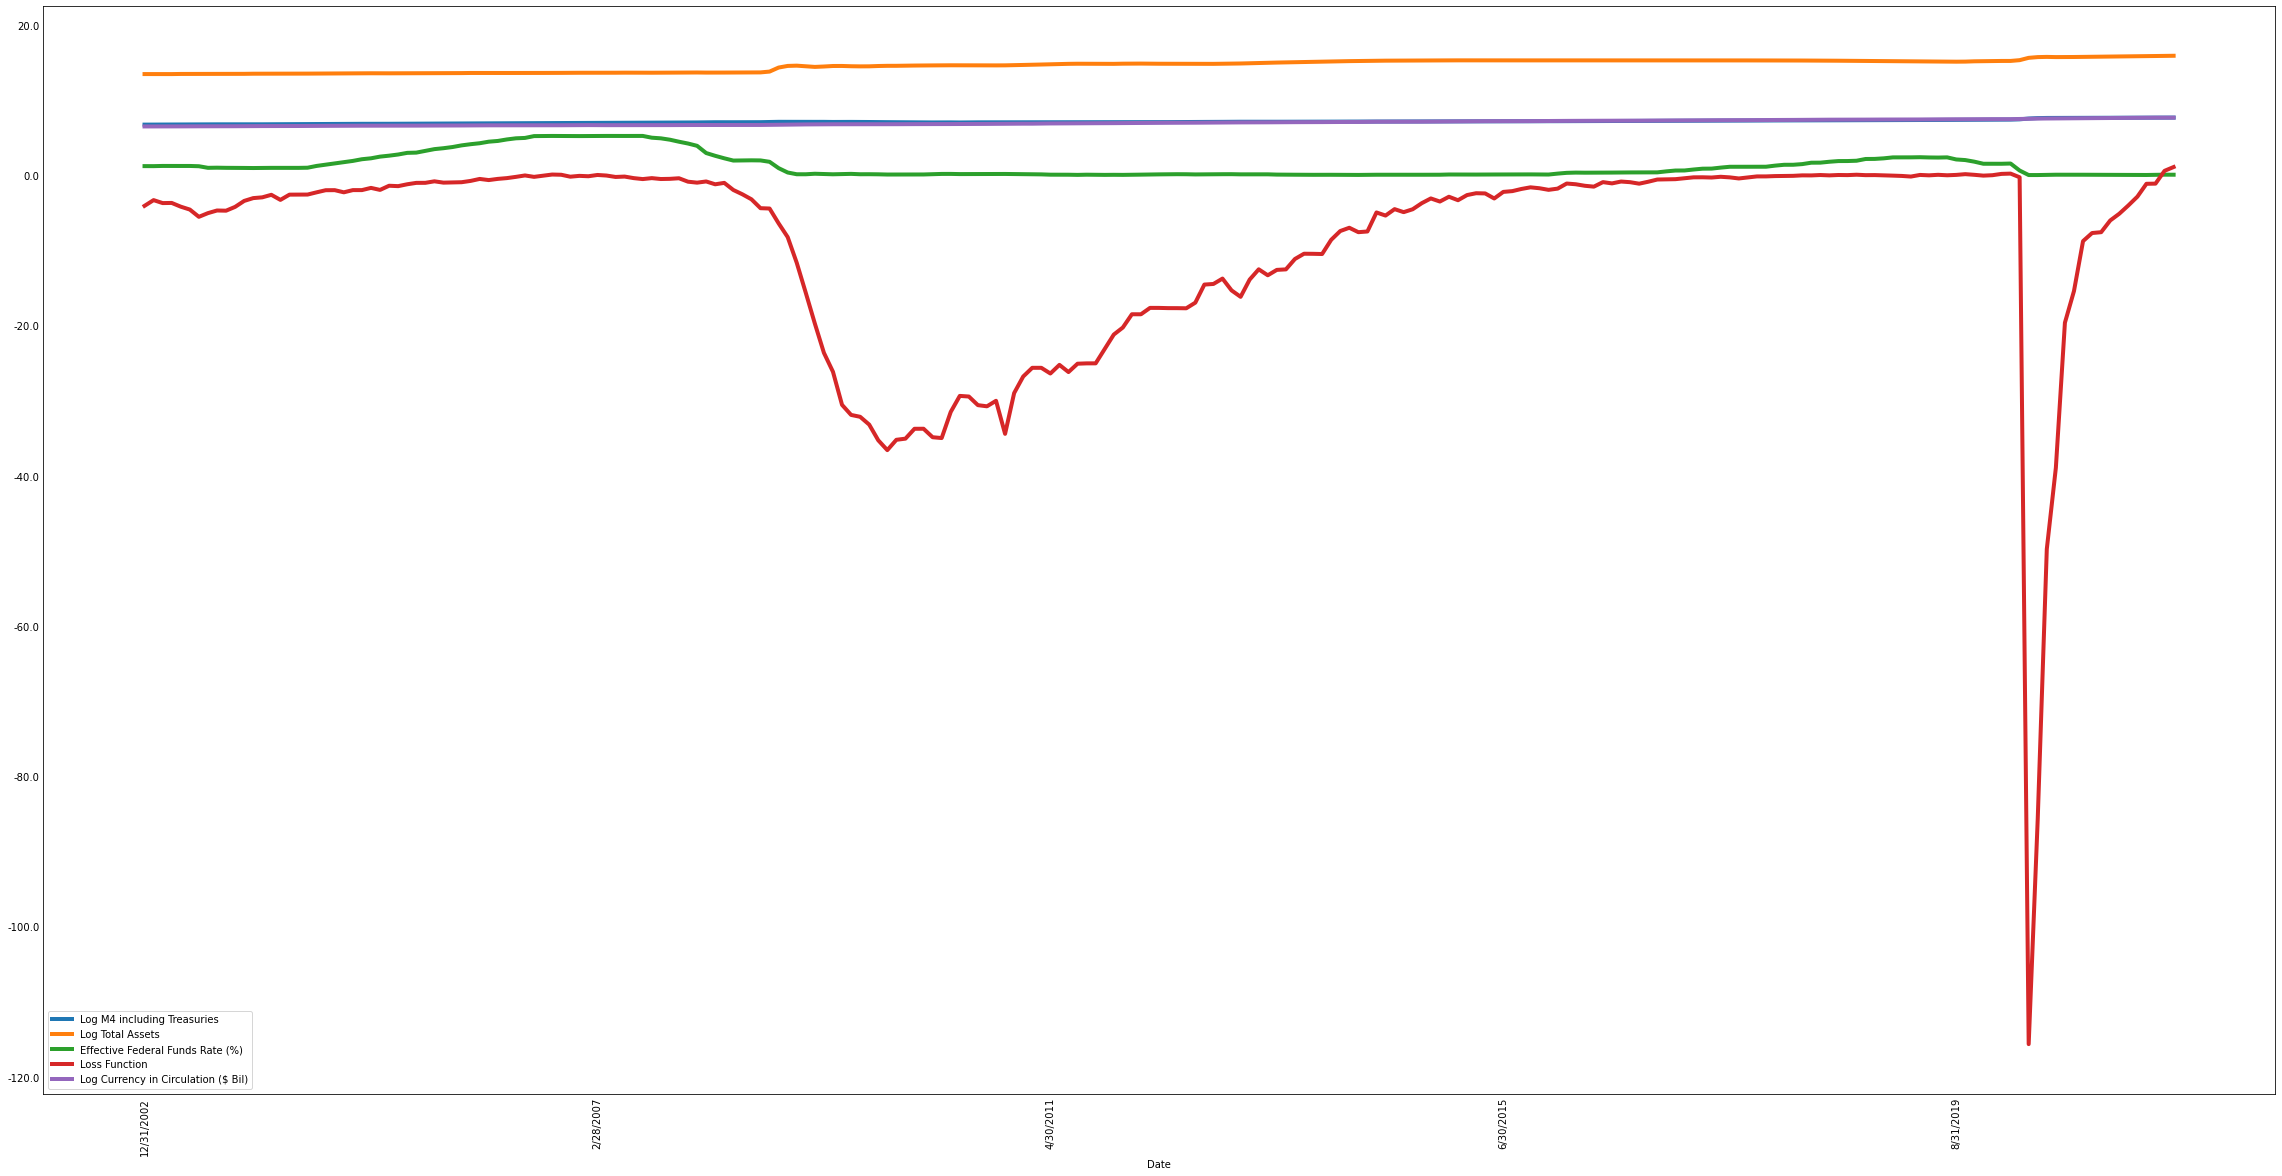

In [19]:
from datlib.plots import * 
plot_variables = ["Log M4 including Treasuries", "Log Total Assets", "Effective Federal Funds Rate (%)", "Loss Function", "Log Currency in Circulation ($ Bil)"]
plot_lines(data[plot_variables], linewidth=4)

In [20]:
## ADF test

In [23]:
X = data["Log M4 including Treasuries"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Effective Federal Funds Rate (%)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Log Total Assets"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Log Currency in Circulation ($ Bil)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data["Loss Function"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    

ADF Statistic: 1.074702
p-value: 0.994995
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -2.985840
p-value: 0.036238
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Reject Ho - Time Series is Stationary
ADF Statistic: -0.476791
p-value: 0.896467
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: 2.119026
p-value: 0.998809
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -4.705669
p-value: 0.000082
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Reject Ho - Time Series is Stationary


In [24]:
data_diff = data.diff(year).dropna()
data_diff

,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Loss Function,Log Currency in Circulation ($ Bil)
Date,,,,,
12/31/2003,0.038,0.046,-0.254,1.032,0.05
1/31/2004,0.037,0.047,-0.238,0.369,0.05
2/29/2004,0.039,0.044,-0.255,1.102,0.05
3/31/2004,0.044,0.043,-0.251,0.405,0.04
4/30/2004,0.047,0.034,-0.254,1.602,0.04
...,...,...,...,...,...
4/30/2021,0.116,0.211,0.020,112.840,0.14
5/31/2021,0.069,0.124,0.008,84.519,0.11
6/30/2021,0.046,0.118,0.000,48.659,0.11


In [25]:
X = data_diff["Log M4 including Treasuries"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["Effective Federal Funds Rate (%)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["Log Total Assets"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["Log Currency in Circulation ($ Bil)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["Loss Function"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.390630
p-value: 0.586760
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -2.945570
p-value: 0.040300
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
Reject Ho - Time Series is Stationary
ADF Statistic: -2.947258
p-value: 0.040122
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
Reject Ho - Time Series is Stationary
ADF Statistic: -1.429323
p-value: 0.568140
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -3.184943
p-value: 0.020873
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575
Reject Ho - Time Series is Stationary


In [26]:
data_new = data_diff.diff(year).dropna()

In [27]:
data_new

,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Loss Function,Log Currency in Circulation ($ Bil)
Date,,,,,
12/31/2004,0.032,0.017,1.426,0.033,-8.881784e-16
1/31/2005,0.026,0.013,1.520,0.889,-8.881784e-16
2/28/2005,0.021,0.016,1.750,-0.450,-8.881784e-16
3/31/2005,0.009,0.017,1.878,1.479,1.000000e-02
4/30/2005,0.004,0.019,2.035,-0.470,1.000000e-02
...,...,...,...,...,...
4/30/2021,-0.084,-0.260,2.395,228.572,5.000000e-02
5/31/2021,-0.182,-0.461,2.349,170.165,-8.881784e-16
6/30/2021,-0.220,-0.500,2.300,98.492,-1.000000e-02


In [28]:
X = data_new["Log M4 including Treasuries"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Effective Federal Funds Rate (%)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Log Total Assets"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Log Currency in Circulation ($ Bil)"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["Loss Function"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -3.320076
p-value: 0.014005
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary
ADF Statistic: -3.094704
p-value: 0.026948
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary
ADF Statistic: -3.259120
p-value: 0.016808
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary
ADF Statistic: -3.227653
p-value: 0.018439
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary
ADF Statistic: -2.885514
p-value: 0.047059
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Reject Ho - Time Series is Stationary


In [31]:
df = data_new
df

,Log M4 including Treasuries,Log Total Assets,Effective Federal Funds Rate (%),Loss Function,Log Currency in Circulation ($ Bil)
Date,,,,,
12/31/2004,0.032,0.017,1.426,0.033,-8.881784e-16
1/31/2005,0.026,0.013,1.520,0.889,-8.881784e-16
2/28/2005,0.021,0.016,1.750,-0.450,-8.881784e-16
3/31/2005,0.009,0.017,1.878,1.479,1.000000e-02
4/30/2005,0.004,0.019,2.035,-0.470,1.000000e-02
...,...,...,...,...,...
4/30/2021,-0.084,-0.260,2.395,228.572,5.000000e-02
5/31/2021,-0.182,-0.461,2.349,170.165,-8.881784e-16
6/30/2021,-0.220,-0.500,2.300,98.492,-1.000000e-02


In [32]:
## Johansen test

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Log M4 including Treasuries ::  137.55    > 60.0627   =>   True
Log Total Assets ::  76.88     > 40.1749   =>   True
Effective Federal Funds Rate (%) ::  46.16     > 24.2761   =>   True
Loss Function ::  25.2      > 12.3212   =>   True
Log Currency in Circulation ($ Bil) ::  8.28      > 4.1296    =>   True


In [ ]:
# test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
# test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
test_results = diag.acorr_ljungbox(est.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypthoesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypthoesis, so there is autocorrelation.")
    print('-'*100)

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

In [35]:
##Testing Causation using Granger’s Causality Test

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data_new, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data_new[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,Log M4 including Treasuries_x,Log Total Assets_x,Effective Federal Funds Rate (%)_x,Loss Function_x,Log Currency in Circulation ($ Bil)_x
Log M4 including Treasuries_y,1.0000,0.0104,0.0,0.0000,0.0000
Log Total Assets_y,0.0005,1.0000,0.0,0.1794,0.0005
Effective Federal Funds Rate (%)_y,0.0000,0.0000,1.0,0.0000,0.0000
Loss Function_y,0.0000,0.1287,0.0,1.0000,0.0001
Log Currency in Circulation ($ Bil)_y,0.0000,0.0000,0.0,0.0002,1.0000


In [36]:
## How to Select the Order (P) of VAR model

model = VAR(df)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -19.438910903783636
BIC :  -18.94416329880143
FPE :  3.6126623073302754e-09
HQIC:  -19.2386941161412 

Lag Order = 2
AIC :  -20.214568469671942
BIC :  -19.304358593491806
FPE :  1.6640616443838457e-09
HQIC:  -19.846183012628252 

Lag Order = 3
AIC :  -20.49255931911732
BIC :  -19.16396657944276
FPE :  1.2617155587772446e-09
HQIC:  -19.95478913830256 

Lag Order = 4
AIC :  -20.47762538177679
BIC :  -18.727694460368216
FPE :  1.283647899653554e-09
HQIC:  -19.769240290871345 

Lag Order = 5
AIC :  -20.74505187604012
BIC :  -18.570792153081104
FPE :  9.861745346364814e-10
HQIC:  -19.86480733482736 

Lag Order = 6
AIC :  -20.94477640598707
BIC :  -18.343161372256915
FPE :  8.122790814172788e-10
HQIC:  -19.891413294100317 

Lag Order = 7
AIC :  -21.039893033364812
BIC :  -18.007859689903995
FPE :  7.446239746544957e-10
HQIC:  -19.812137419631966 

Lag Order = 8
AIC :  -21.361411336800174
BIC :  -17.89585958174576
FPE :  5.459134354693993e-10
HQIC:  -19.95797424408711 

L

C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [42]:
x = model.select_order(maxlags=29)
x.summary()

,AIC,BIC,FPE,HQIC
0,-9.058,-8.966,0.0001165,-9.021
1,-18.93,-18.38,5.997e-09,-18.71
2,-19.81,-18.80,2.496e-09,-19.40
3,-20.10,-18.64,1.871e-09,-19.51
4,-20.09,-18.17,1.888e-09,-19.31
5,-20.42,-18.04,1.365e-09,-19.46
6,-20.69,-17.86,1.050e-09,-19.54
7,-20.86,-17.56,9.029e-10,-19.52
8,-21.15,-17.40,6.819e-10,-19.63
9,-21.94,-17.73,3.172e-10,-20.23


In [70]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Mar, 2022
Time:                     11:33:23
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -18.5031
Nobs:                     177.000    HQIC:                  -21.7565
Log likelihood:           1171.13    FPE:                4.47876e-11
AIC:                     -23.9762    Det(Omega_mle):     1.01892e-11
--------------------------------------------------------------------
Results for equation Log M4 including Treasuries
                                             coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------
const                                          -0.000075         0.001003           -0.075           0.941
L1.Log M4 including Treasuries           

In [38]:
var = VAR(df)

C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [39]:
x= var.select_order()
x.summary()

,AIC,BIC,FPE,HQIC
0,-9.407,-9.321,8.213e-05,-9.372
1,-19.26,-18.74,4.338e-09,-19.05
2,-20.10,-19.15*,1.860e-09,-19.72
3,-20.37,-18.99,1.421e-09,-19.81
4,-20.37,-18.55,1.436e-09,-19.63
5,-20.67,-18.42,1.065e-09,-19.76
6,-20.93,-18.25,8.285e-10,-19.84
7,-21.04,-17.93,7.479e-10,-19.78
8,-21.34,-17.79,5.622e-10,-19.90
9,-22.00,-18.03,2.938e-10,-20.39


In [68]:
results = var.fit(12)
#We can check the summary of the model by.
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Mar, 2022
Time:                     10:43:52
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -18.1874
Nobs:                     189.000    HQIC:                  -21.2995
Log likelihood:           1177.18    FPE:                7.60829e-11
AIC:                     -23.4188    Det(Omega_mle):     1.87887e-11
--------------------------------------------------------------------
Results for equation Log M4 including Treasuries
                                             coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------
const                                           0.000002         0.001008            0.002           0.998
L1.Log M4 including Treasuries           

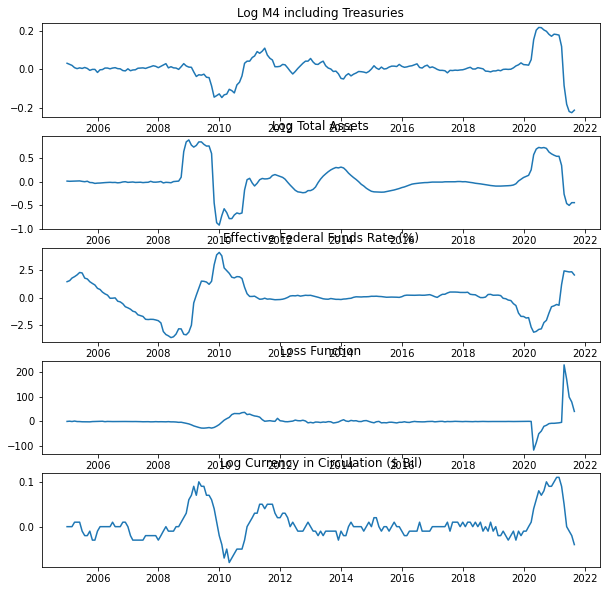

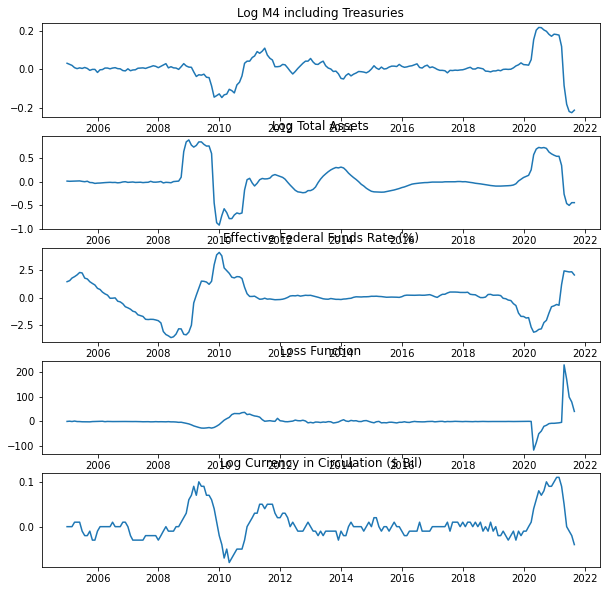

In [44]:
results.plot()

In [48]:
train_df=df[:-12]
test_df=df[-12:]

In [49]:
print(test_df.shape)

(12, 5)


In [50]:
model = VAR(train_df)

C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [69]:
from statsmodels.tsa.statespace.varmax import VARMAX

var_model = VARMAX(train_df, order=(12,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                                                          Statespace Model Results                                                                                         
Dep. Variable:     ['Log M4 including Treasuries', 'Log Total Assets', 'Effective Federal Funds Rate (%)', 'Loss Function', 'Log Currency in Circulation ($ Bil)']   No. Observations:                  189
Model:                                                                                                                                                     VAR(12)   Log Likelihood                -153.262
                                                                                                                                                       + intercept   AIC                            946.524
Date:                                                                                                                                             Wed, 23 Mar 2022   BIC                

In [66]:
## KPSS test

In [58]:
import statsmodels.api as sm

#perform KPSS test
sm.tsa.stattools.kpss(data_new["Loss Function"], regression='ct')

C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.05738044261634268,
 0.1,
 15,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [ ]:
The p-value is 0.1. Since this value is not less than .05, we fail to reject the null hypothesis of the KPSS test.
This means we can assume that the time series is trend stationary

In [59]:
sm.tsa.stattools.kpss(data_new["Log Total Assets"], regression='ct')

C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.05804293130478858,
 0.1,
 15,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [63]:
sm.tsa.stattools.kpss(data_new["Log Currency in Circulation ($ Bil)"], regression='ct')

C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.06787954420174813,
 0.1,
 15,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [64]:
sm.tsa.stattools.kpss(data_new["Log M4 including Treasuries"], regression='ct')

C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.0492085820915457,
 0.1,
 15,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [65]:
sm.tsa.stattools.kpss(data_new["Effective Federal Funds Rate (%)"], regression='ct')

C:\Users\proma.gupta\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.05343689789746268,
 0.1,
 15,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [67]:
df.to_csv("M4.csv")